In [26]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.ndimage import gaussian_filter1d
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [17]:
PODCONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/pod/configs.json'
NNCONFIGSPATH  = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/nn/configs.json'
SPLIT          = 'valid'
LANDTHRESH     = 0.5
PRTHRESH       = 0.01

In [18]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=LANDTHRESH):
    if dims is None:
        dims = list(ytrue.dims)
    if landfrac is not None:
        landmask  = landfrac>=LANDTHRESH
        oceanmask = landfrac<LANDTHRESH
        ytrueland = ytrue.where(landmask)
        ypredland = ypred.where(landmask)
        ssresland = ((ytrueland-ypredland)**2).sum(dim=dims,skipna=True)
        sstotland = ((ytrueland-ytrueland.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
        r2land = 1-(ssresland/sstotland)
        ytrueocean = ytrue.where(oceanmask)
        ypredocean = ypred.where(oceanmask)
        ssresocean = ((ytrueocean-ypredocean)**2).sum(dim=dims,skipna=True)
        sstotocean = ((ytrueocean-ytrueocean.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
        r2ocean = 1-(ssresocean/sstotocean)
        return float(r2land.values),float(r2ocean.values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    r2 = 1-(ssres/sstot)
    return r2

In [37]:
with open(PODCONFIGSPATH,'r',encoding='utf-8') as f:
    PODCONFIGS = json.load(f)
PODFILEDIR     = PODCONFIGS['paths']['filedir']
PODRESULTSDIR  = PODCONFIGS['paths']['resultsdir']
PODRUN         = PODCONFIGS['runs'][1]

podtruepath = os.path.join(PODFILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(podtruepath,engine='h5netcdf') as ds:
    podtruepr = ds['pr'].load()

podpredpath = os.path.join(PODRESULTSDIR,f'pod_{PODRUN["run_name"]}_{SPLIT}_pr.nc')
with xr.open_dataset(podpredpath,engine='h5netcdf') as ds:
    podpredpr = ds['pr'].load()

podytrue,podypred = xr.align(podtruepr,podpredpr,join='inner')
podr2 = float(get_r2(podytrue,podypred,dims=None).values)

summaryrows = [{
    'model_id':PODRUN['run_name'],
    'label':'Baseline',
    'family':'Baseline',
    'r2':podr2}]

In [38]:
with open(NNCONFIGSPATH,'r',encoding='utf-8') as f:
    NNCONFIGS = json.load(f)
NNFILEDIR     = NNCONFIGS['paths']['filedir']
NNRESULTSDIR  = NNCONFIGS['paths']['resultsdir']
NNRUNS        = NNCONFIGS['runs']

nntruepath = os.path.join(NNFILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(nntruepath,engine='h5netcdf') as ds:
    nntruepr = ds['pr'].load()

for i,run in enumerate(NNRUNS):
    runname    = run['run_name']
    nnpredpath = os.path.join(NNRESULTSDIR,f'nn_{runname}_norm_{SPLIT}_pr.nc')
    with xr.open_dataset(nnpredpath,engine='h5netcdf') as ds:
        nnpredpr = ds['pr'].load()
    nnytrue,nnypred = xr.align(nntruepr,nnpredpr,join='inner')
    nnr2 = float(get_r2(nnytrue,nnypred,dims=None).values)
    summaryrows.append({
        'model_id':runname,
        'label':f'Experiment {i+1}',
        'family':'NN',
        'r2':nnr2})

In [39]:
df = pd.DataFrame(summaryrows)

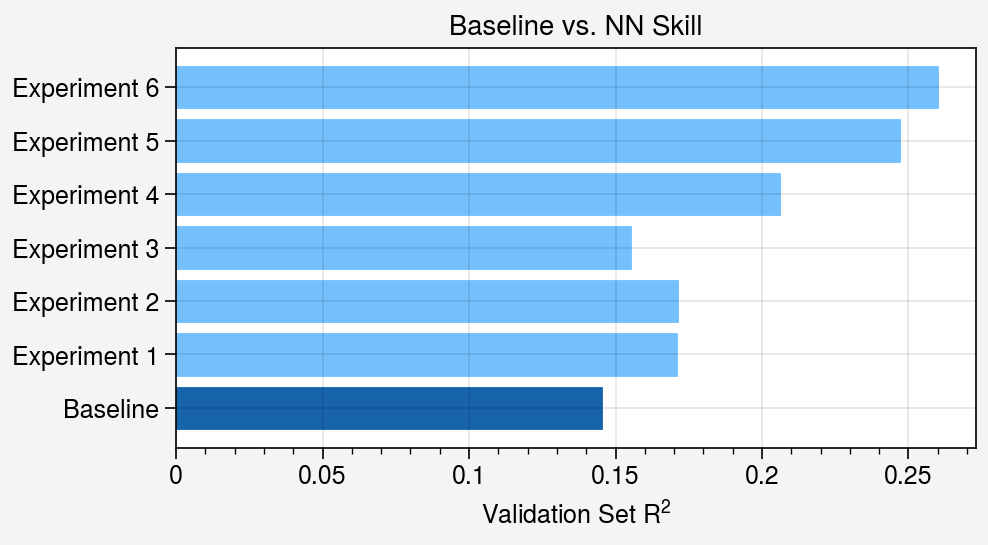

In [40]:
colors = ['blue9' if family=='Baseline' else 'blue3' for family in df['family']]

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=2)
ax.format(title='Baseline vs. NN Skill',xlabel='Validation Set R$^2$',ylabel='')
ax.barh(df['label'],df['r2'],color=colors)
pplt.show()

fig.save('compare.png',dpi=900)

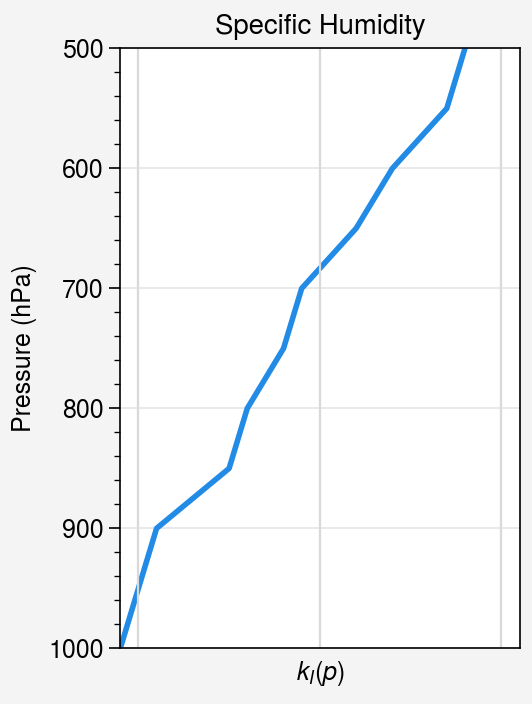

In [42]:
levels  = np.array([1000,950,900,850,800,750,700,650,600,550,500])
xvalues = np.array([0.05,0.06,0.07,0.11,0.12,0.14,0.15,0.18,0.20,0.23,0.24])

kmean = 0.2+(xvalues/xvalues.max())*1.2
kstd  = 0.15*kmean
klower = kmean-kstd
kupper = kmean+kstd

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2,refheight=3)
ax.format(title='Specific Humidity',xlabel=r'$\mathit{k}_\mathit{I}(\mathit{p})$',xticks=25,
          ylabel='Pressure (hPa)',ylim=(1000,500))
# ax.fill_betweenx(levels,klower,kupper,alpha=0.25,color='blue6')
ax.plot(kmean,levels,color='blue6',linewidth=2)

for xref in [0.5,1.0,1.5]:
    ax.axvline(xref,color='0.85',linewidth=0.8)

pplt.show()
fig.save('example.png',dpi=900)